# Exponential smoothing 

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [23]:
plt.rcParams["figure.figsize"] = (9,6)

In [24]:
df = pd.read_csv('data/h02.csv', index_col=0)
df.head()

,time,value
1,1991.500000,0.429795
2,1991.583333,0.400906
3,1991.666667,0.432159
4,1991.750000,0.492543
5,1991.833333,0.502369


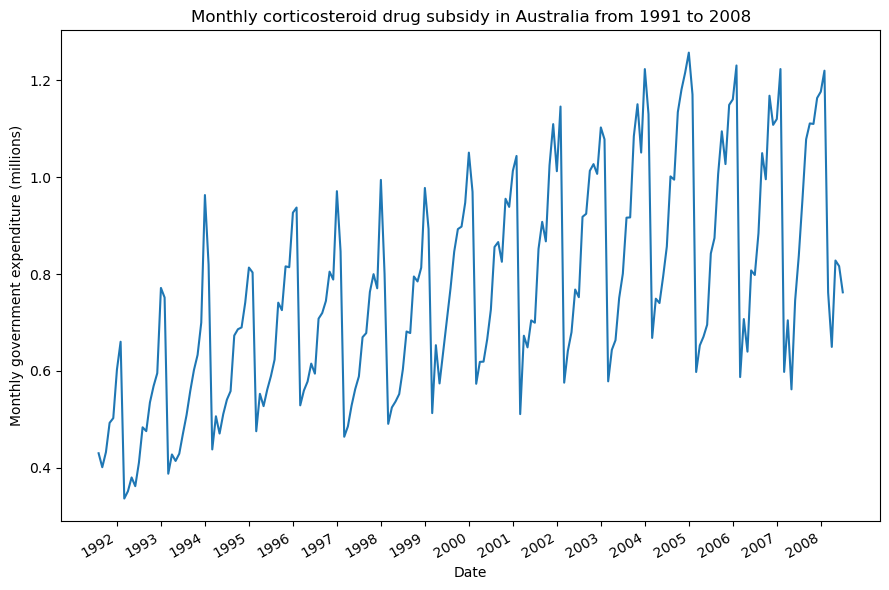

In [25]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Date')
ax.set_ylabel('Monthly government expenditure (millions)')

plt.xticks(np.arange(6, 204, 12), np.arange(1992, 2009, 1))

plt.title('Monthly corticosteroid drug subsidy in Australia from 1991 to 2008')

fig.autofmt_xdate()
plt.tight_layout()

## Simple exponential smoothing

In [26]:
train = df[:-36]
test = df[-36:]

In [27]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df[:i].iloc[-12:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'simple_exp':
        pred_simple_exp = []
        
        for i in range(train_len, total_len, window):
            ses = SimpleExpSmoothing(df[:i], initialization_method='estimated').fit()
            predictions = ses.forecast(window)
            pred_simple_exp.extend(predictions)

        print(f"alpha = {ses.model.params['smoothing_level']}")

        return pred_simple_exp

In [28]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 12

pred_last_season = rolling_forecast(df['value'], TRAIN_LEN, HORIZON, WINDOW, 'last_season')
pred_simple_exp = rolling_forecast(df['value'], TRAIN_LEN, HORIZON, WINDOW, 'simple_exp')

test.loc[:, 'pred_last_season'] = pred_last_season
test.loc[:, 'pred_simple_exp'] = pred_simple_exp

test.head()

alpha = 0.8657938251313414


,time,value,pred_last_season,pred_simple_exp
169,2005.500000,0.874336,1.001593,0.828866
170,2005.583333,1.006497,0.994864,0.828866
171,2005.666667,1.094736,1.134432,0.828866
172,2005.750000,1.027043,1.181011,0.828866
173,2005.833333,1.149232,1.216037,0.828866


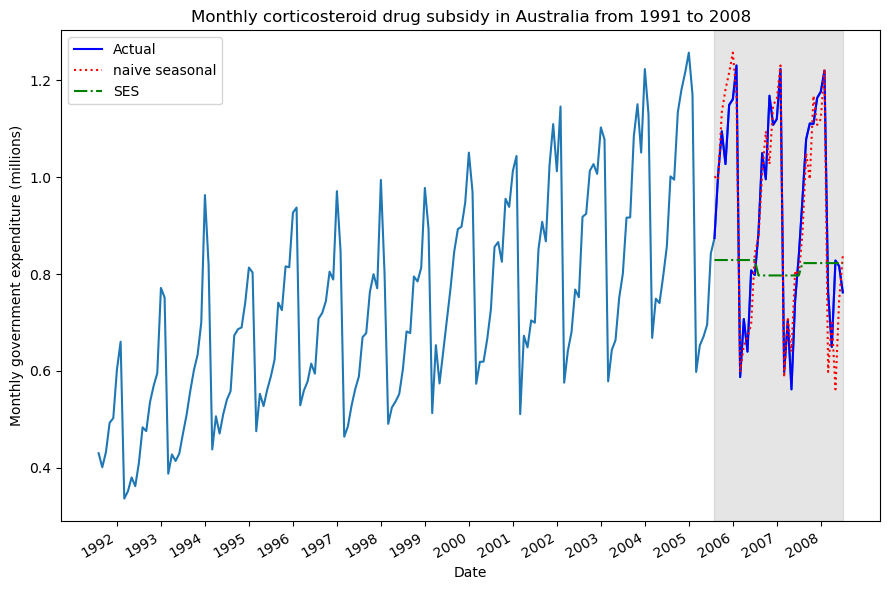

In [29]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.plot(test['value'], 'b-', label='Actual')
ax.plot(test['pred_last_season'], 'r:', label='naive seasonal')
ax.plot(test['pred_simple_exp'], 'g-.', label='SES')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly government expenditure (millions)')
ax.axvspan(169, 204, color='#808080', alpha=0.2)
ax.legend(loc='best')

plt.xticks(np.arange(6, 204, 12), np.arange(1992, 2009, 1))

plt.title('Monthly corticosteroid drug subsidy in Australia from 1991 to 2008')

fig.autofmt_xdate()
plt.tight_layout()

### Evaluation 

In [30]:
from sklearn.metrics import mean_absolute_error

baseline_mae = mean_absolute_error(test['value'], test['pred_last_season'])
ses_mae = mean_absolute_error(test['value'], test['pred_simple_exp'])

print(baseline_mae, ses_mae)

0.06675405833333337 0.20272286665130343


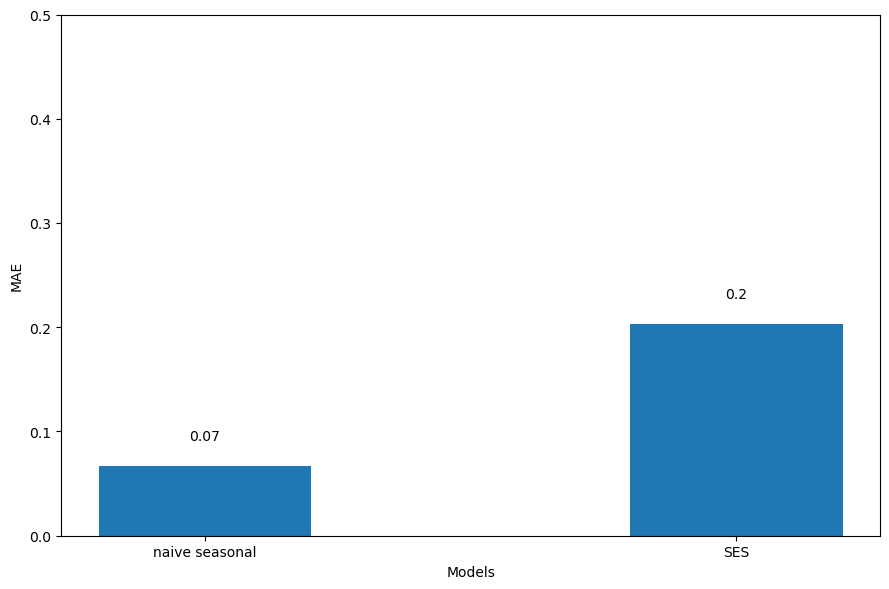

In [31]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SES']
y = [baseline_mae, ses_mae]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 0.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.025, s=str(round(value,2)), ha='center')

plt.tight_layout()

## Double exponential smoothing 

In [32]:
from statsmodels.tsa.holtwinters import Holt

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df[:i].iloc[-12:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'simple_exp':
        pred_simple_exp = []
        
        for i in range(train_len, total_len, window):
            ses = SimpleExpSmoothing(df[:i], initialization_method='estimated').fit()
            predictions = ses.forecast(window)
            pred_simple_exp.extend(predictions)
            
        return pred_simple_exp
    
    elif method == 'double_exp':
        pred_double_exp = []
        
        for i in range(train_len, total_len, window):
            des = Holt(df[:i], initialization_method='estimated').fit()
            predictions = des.forecast(window)
            pred_double_exp.extend(predictions)
            
        print(f"alpha = {des.model.params['smoothing_level']}")
        print(f"beta = {des.model.params['smoothing_trend']}")
        
        return pred_double_exp
    
    elif method == 'double_exp_damp':
        pred_double_exp_damp = []
        
        for i in range(train_len, total_len, window):
            des_damp = Holt(df[:i],damped_trend=True, initialization_method='estimated').fit()
            predictions = des_damp.forecast(window)
            pred_double_exp_damp.extend(predictions)
            
        print(f"alpha = {des_damp.model.params['smoothing_level']}")
        print(f"beta = {des_damp.model.params['smoothing_trend']}")
        
        return pred_double_exp_damp

In [33]:
pred_double_exp = rolling_forecast(df['value'], TRAIN_LEN, HORIZON, WINDOW, 'double_exp')
pred_double_exp_damp = rolling_forecast(df['value'], TRAIN_LEN, HORIZON, WINDOW, 'double_exp_damp')

test.loc[:, 'pred_double_exp'] = pred_double_exp
test.loc[:, 'pred_double_exp_damp'] = pred_double_exp_damp

test.head()

alpha = 0.8655639259934514
beta = 1.3091748032201239e-14
alpha = 0.8651110249180488
beta = 1.9923463371855775e-14


,time,value,pred_last_season,pred_simple_exp,pred_double_exp,pred_double_exp_damp
169,2005.500000,0.874336,1.001593,0.828866,0.831482,0.829358
170,2005.583333,1.006497,0.994864,0.828866,0.833909,0.829902
171,2005.666667,1.094736,1.134432,0.828866,0.836337,0.830438
172,2005.750000,1.027043,1.181011,0.828866,0.838764,0.830966
173,2005.833333,1.149232,1.216037,0.828866,0.841191,0.831487


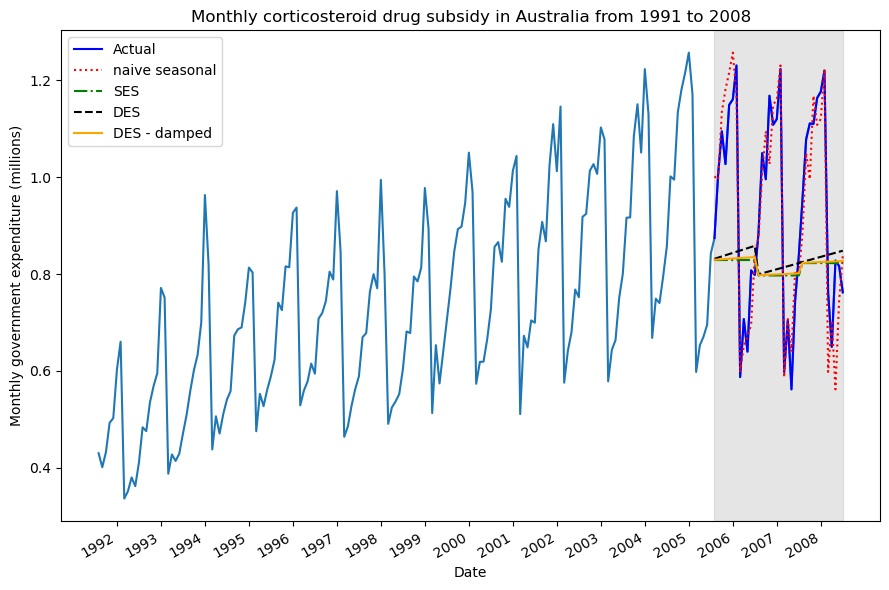

In [34]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.plot(test['value'], 'b-', label='Actual')
ax.plot(test['pred_last_season'], 'r:', label='naive seasonal')
ax.plot(test['pred_simple_exp'], 'g-.', label='SES')
ax.plot(test['pred_double_exp'], 'k--', label='DES')
ax.plot(test['pred_double_exp_damp'], color='orange', label='DES - damped')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly government expenditure (millions)')
ax.axvspan(169, 204, color='#808080', alpha=0.2)
ax.legend(loc='best')


plt.xticks(np.arange(6, 204, 12), np.arange(1992, 2009, 1))

plt.title('Monthly corticosteroid drug subsidy in Australia from 1991 to 2008')

fig.autofmt_xdate()
plt.tight_layout()

In [35]:
des_mae = mean_absolute_error(test['value'], test['pred_double_exp'])
des_damp_mae = mean_absolute_error(test['value'], test['pred_double_exp_damp'])

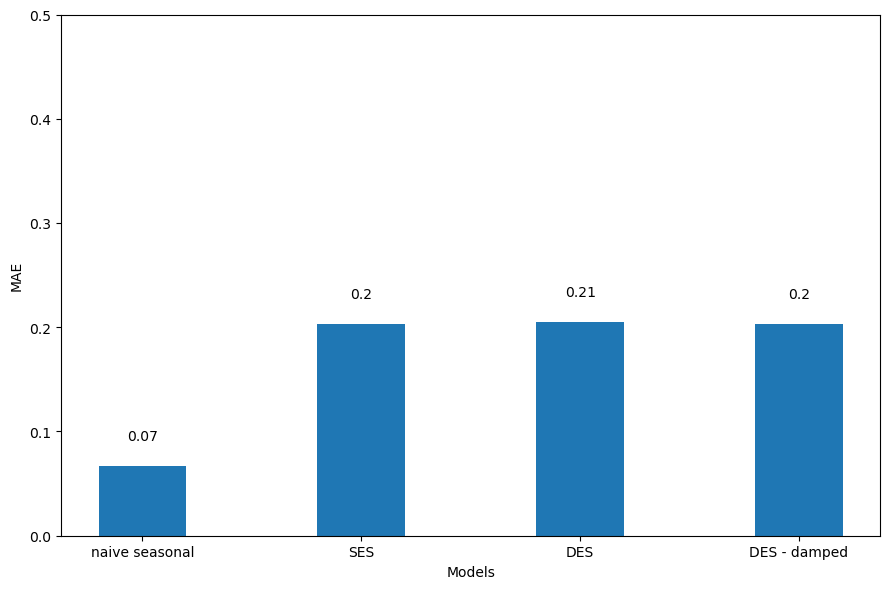

In [36]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SES', 'DES', 'DES - damped']
y = [baseline_mae, ses_mae, des_mae, des_damp_mae]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 0.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.025, s=str(round(value,2)), ha='center')

plt.tight_layout()

## Triple exponential smoothing

In [37]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df[:i].iloc[-12:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'simple_exp':
        pred_simple_exp = []
        
        for i in range(train_len, total_len, window):
            ses = SimpleExpSmoothing(df[:i], initialization_method='estimated').fit()
            predictions = ses.forecast(window)
            pred_simple_exp.extend(predictions)
            
        return pred_simple_exp
    
    elif method == 'double_exp':
        pred_double_exp = []
        
        for i in range(train_len, total_len, window):
            des = Holt(df[:i], initialization_method='estimated').fit()
            predictions = des.forecast(window)
            pred_double_exp.extend(predictions)
            
        return pred_double_exp
    
    elif method == 'double_exp_damp':
        pred_double_exp_damp = []
        
        for i in range(train_len, total_len, window):
            des_damp = Holt(df[:i],damped_trend=True, initialization_method='estimated').fit()
            predictions = des_damp.forecast(window)
            pred_double_exp_damp.extend(predictions)
            
        return pred_double_exp_damp
    
    elif method == 'triple_exp':
        pred_triple_exp = []
        
        for i in range(train_len, total_len, window):
            tes = ExponentialSmoothing(df[:i],
                                       trend='add',
                                       seasonal='additive',
                                       seasonal_periods=12,
                                       initialization_method='estimated').fit()
            predictions = tes.forecast(window)
            pred_triple_exp.extend(predictions)
            
        print(f"alpha = {tes.model.params['smoothing_level']}")
        print(f"beta = {tes.model.params['smoothing_trend']}")
        print(f"gamma = {tes.model.params['smoothing_seasonal']}")

        return pred_triple_exp

In [38]:
pred_triple_exp = rolling_forecast(df['value'], TRAIN_LEN, HORIZON, WINDOW, 'triple_exp')

test.loc[:, 'pred_triple_exp'] = pred_triple_exp

test.head()

alpha = 0.20109143822410128
beta = 1.1224346395847781e-18
gamma = 0.5142313167077245


,time,value,pred_last_season,pred_simple_exp,pred_double_exp,pred_double_exp_damp,pred_triple_exp
169,2005.500000,0.874336,1.001593,0.828866,0.831482,0.829358,0.969482
170,2005.583333,1.006497,0.994864,0.828866,0.833909,0.829902,0.967664
171,2005.666667,1.094736,1.134432,0.828866,0.836337,0.830438,1.100147
172,2005.750000,1.027043,1.181011,0.828866,0.838764,0.830966,1.143413
173,2005.833333,1.149232,1.216037,0.828866,0.841191,0.831487,1.133816


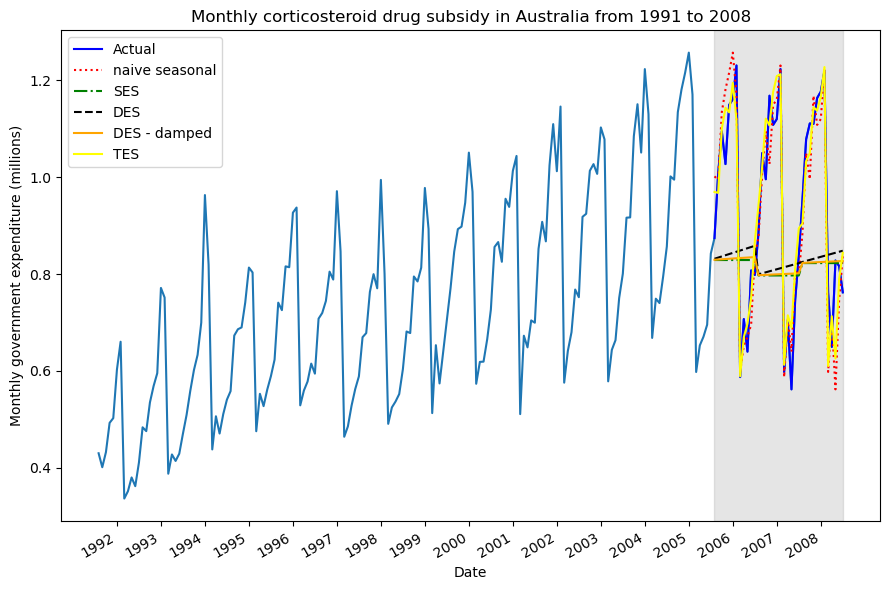

In [39]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.plot(test['value'], 'b-', label='Actual')
ax.plot(test['pred_last_season'], 'r:', label='naive seasonal')
ax.plot(test['pred_simple_exp'], 'g-.', label='SES')
ax.plot(test['pred_double_exp'], 'k--', label='DES')
ax.plot(test['pred_double_exp_damp'], color='orange', label='DES - damped')
ax.plot(test['pred_triple_exp'], color='yellow', label='TES')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly government expenditure (millions)')
ax.axvspan(169, 204, color='#808080', alpha=0.2)
ax.legend(loc='best')


plt.xticks(np.arange(6, 204, 12), np.arange(1992, 2009, 1))

plt.title('Monthly corticosteroid drug subsidy in Australia from 1991 to 2008')

fig.autofmt_xdate()
plt.tight_layout()

In [40]:
tes_mae = mean_absolute_error(test['value'], test['pred_triple_exp'])

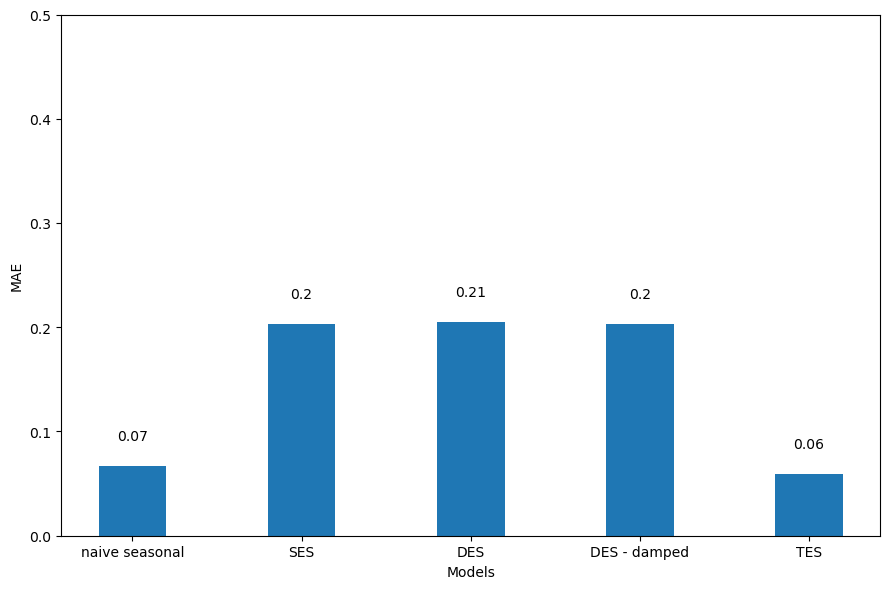

In [41]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SES', 'DES', 'DES - damped', 'TES']
y = [baseline_mae, ses_mae, des_mae, des_damp_mae, tes_mae]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 0.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.025, s=str(round(value,2)), ha='center')

plt.tight_layout()